In [268]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
import subprocess
import seaborn as sns

## Read in Data

The files have already been preprocessed in R in `utils.R`

Those were the parts for 1.1 and 1.2

In [3]:
biogrid_lcc = pd.read_csv("Files/Biogrid.txt", sep='\t')
huri_lcc = pd.read_csv("Files/Huri.txt", sep='\t')
string_lcc = pd.read_csv("Files/String.txt", sep='\t')
reactome_lcc = pd.read_csv("Files/Reactome.txt", sep='\t')

interactomes_lcc = [biogrid_lcc, huri_lcc, string_lcc, reactome_lcc]

disease = pd.read_csv("Files/Cardiomyopathy.txt").iloc[:,0].tolist()

In [4]:
biogrid_lcc.head()

,GeneA,GeneB
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3


Build graph of interactome LCC size to find all the nodes and links (not just disease)

In [5]:
def create_graph(df, name):
    """
    Function th create graph

    Params :
    - df : the interactome
    - name : name of the graph

    Returns : instance of nxGraph
    """
    # Create instance of graph
    graph = nx.Graph(name = name)

    edges = []
    for i in range(0,df.shape[0]):
        # For each row, we add it as an edge
        edges.append((df.iloc[i,0],df.iloc[i,1]))
    
    # Get list of *unique* genes among "GeneA" and "GeneB" columns
    nodes = list(set(df["GeneA"]) | set(df["GeneB"]))

    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)

    return graph

In [6]:
print("Running for ~3 minutes...")

biogrid_lcc_graph = create_graph(biogrid_lcc, "biogrid_interactions")
huri_lcc_graph = create_graph(huri_lcc, "huri_interactions")
string_lcc_graph = create_graph(string_lcc, "string_interactions")
reactome_lcc_graph = create_graph(reactome_lcc, "reactome_interactions")

Running for ~3 minutes...


### 1.3. Compute and characterize the disease LCC 

1.3.1 Check for the presence of disease genes in the LCCs of each interactome and identify the disease interactomes by getting the
interactions among disease genes

In [7]:
# 1. We get the set of disease genes included in "GeneA" and "GeneB" for each interactome
# 2. Then we create a new "sub-interactome" made only of disease genes interactions

biogrid_filter = biogrid_lcc["GeneA"].isin(disease) & biogrid_lcc["GeneB"].isin(disease)
biogrid_disease_interactions = biogrid_lcc[biogrid_filter].reset_index(drop=True)

huri_filter = huri_lcc["GeneA"].isin(disease) & huri_lcc["GeneB"].isin(disease)
huri_disease_interactions = huri_lcc[huri_filter].reset_index(drop=True)

string_filter = string_lcc["GeneA"].isin(disease) & string_lcc["GeneB"].isin(disease)
string_disease_interactions = string_lcc[string_filter].reset_index(drop=True)

reactome_filter = reactome_lcc["GeneA"].isin(disease) & reactome_lcc["GeneB"].isin(disease)
reactome_disease_interactions = reactome_lcc[reactome_filter].reset_index(drop=True)

In [8]:
# We create a specific graph for the diseases interactions
biogrid_disease_graph = create_graph(biogrid_disease_interactions, "biogrid_disease_interactions")
huri_disease_graph = create_graph(huri_disease_interactions, "huri_disease_interactions")
string_disease_graph = create_graph(string_disease_interactions, "string_disease_interactions")
reactome_disease_graph = create_graph(reactome_disease_interactions, "reactome_disease_interactions")

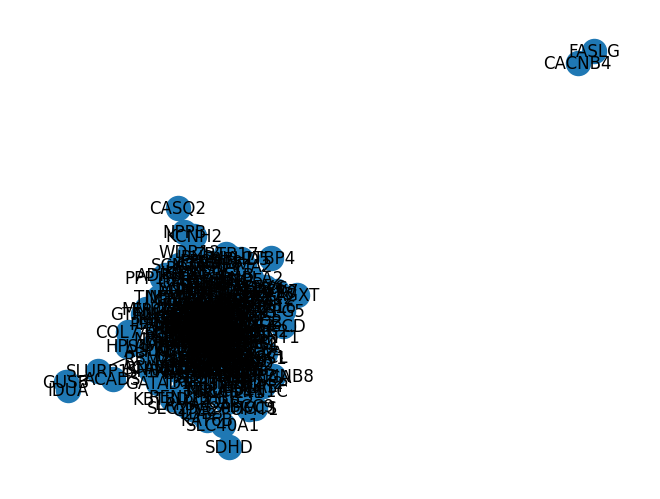

In [9]:
## Visualizing Biogrid disease graph
nx.draw(biogrid_disease_graph, with_labels=True)
plt.show()

1.3.2 Summarize the Interactome and GDA-related data as in table 1

### `Stella` : here you can factorize with for loop :)

#### Check that you have the same results :
`table1 = {'biogrid': {'nodes_edges': (20182, 907435),
  'nbr_disease_genes': 286,
  'percent': 1.42,
  'disease_lcc_size': 284},
 'huri': {'nodes_edges': (8982, 63199),
  'nbr_disease_genes': 35,
  'percent': 0.39,
  'disease_lcc_size': 6},
 'string': {'nodes_edges': (19590, 6844913),
  'nbr_disease_genes': 286,
  'percent': 1.76,
  'disease_lcc_size': 345},
 'reactome': {'nodes_edges': (13262, 272298),
  'nbr_disease_genes': 229,
  'percent': 1.73,
  'disease_lcc_size': 189}}`

In [10]:
table1_dict = {
    'biogrid': {},
    'huri': {},
    'string': {},
    'reactome': {}
}

# 1. Get the size of the original interactome
table1_dict["biogrid"]["nodes_edges"] = (biogrid_lcc_graph.number_of_nodes(), biogrid_lcc_graph.number_of_edges())
table1_dict["huri"]["nodes_edges"] = (huri_lcc_graph.number_of_nodes(), huri_lcc_graph.number_of_edges())
table1_dict["string"]["nodes_edges"] = (string_lcc_graph.number_of_nodes(), string_lcc_graph.number_of_edges())
table1_dict["reactome"]["nodes_edges"] = (reactome_lcc_graph.number_of_nodes(), reactome_lcc_graph.number_of_edges())

# 2. Get the number of unique disease genes present in the interactome
table1_dict["biogrid"]["nbr_disease_genes"] = biogrid_disease_graph.number_of_nodes()
table1_dict["huri"]["nbr_disease_genes"] = huri_disease_graph.number_of_nodes()
table1_dict["string"]["nbr_disease_genes"] = biogrid_disease_graph.number_of_nodes()
table1_dict["reactome"]["nbr_disease_genes"] = reactome_disease_graph.number_of_nodes()

# 3. Get the percentage of disease gene in the interactome
biogrid_all_genes_unique = list(set(biogrid_lcc["GeneA"]) | set(biogrid_lcc["GeneB"]))
percent_biogrid = round((biogrid_disease_graph.number_of_nodes()/biogrid_lcc_graph.number_of_nodes())*100,2)
percent_huri = round((huri_disease_graph.number_of_nodes()/huri_lcc_graph.number_of_nodes())*100,2)
percent_string = round((string_disease_graph.number_of_nodes()/string_lcc_graph.number_of_nodes())*100,2)
percent_reactome = round((reactome_disease_graph.number_of_nodes()/reactome_lcc_graph.number_of_nodes())*100,2)

table1_dict["biogrid"]["percent"] = percent_biogrid
table1_dict["huri"]["percent"] = percent_huri
table1_dict["string"]["percent"] = percent_string
table1_dict["reactome"]["percent"] = percent_reactome

# 4. Get the LCC size of the disease interactome
# To get the LCC of the disease component we extract connected components and sort them from the largest (key: number of nodes) to the smallest
LCC_biogrid_disease = sorted(nx.connected_components(biogrid_disease_graph), key=len, reverse=True)
LCC_biogrid_disease = biogrid_disease_graph.subgraph(LCC_biogrid_disease[0]) # We keep the 1st one (the biggest)
LCC_huri_disease = sorted(nx.connected_components(huri_disease_graph), key=len, reverse=True)
LCC_huri_disease = huri_disease_graph.subgraph(LCC_huri_disease[0]) # We keep the 1st one (the biggest)
LCC_string_disease = sorted(nx.connected_components(string_disease_graph), key=len, reverse=True)
LCC_string_disease = string_disease_graph.subgraph(LCC_string_disease[0]) # We keep the 1st one (the biggest)
LCC_reactome_disease = sorted(nx.connected_components(reactome_disease_graph), key=len, reverse=True)
LCC_reactome_disease = reactome_disease_graph.subgraph(LCC_reactome_disease[0]) # We keep the 1st one (the biggest)

table1_dict["biogrid"]["disease_lcc_size"] = LCC_biogrid_disease.number_of_nodes()
table1_dict["huri"]["disease_lcc_size"] = LCC_huri_disease.number_of_nodes()
table1_dict["string"]["disease_lcc_size"] = LCC_string_disease.number_of_nodes()
table1_dict["reactome"]["disease_lcc_size"] = LCC_reactome_disease.number_of_nodes()

table1_dict

{'biogrid': {'nodes_edges': (20182, 907435),
  'nbr_disease_genes': 286,
  'percent': 1.42,
  'disease_lcc_size': 284},
 'huri': {'nodes_edges': (8982, 63199),
  'nbr_disease_genes': 35,
  'percent': 0.39,
  'disease_lcc_size': 6},
 'string': {'nodes_edges': (19590, 6844913),
  'nbr_disease_genes': 286,
  'percent': 1.76,
  'disease_lcc_size': 345},
 'reactome': {'nodes_edges': (13262, 272298),
  'nbr_disease_genes': 229,
  'percent': 1.73,
  'disease_lcc_size': 189}}

1.3.3 Compute those metrics on the largest disease LCC :
- Node degree
- Betweenness centrality
- Eigenvector centrality
- Closeness centrality
- ratio Betweenness/Node degree

We note that the largest disease LCC is from the String interactome

## `Stella` : don't factorize here, in this part we apply only for the largest compononent. Everything is already good.
When you have read this and took it into account, you can delete this markdown cell ;)

In [11]:
largest_LCC = LCC_string_disease

# Sanity check
assert(largest_LCC.number_of_nodes() >= LCC_biogrid_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_huri_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_string_disease.number_of_nodes())
assert(largest_LCC.number_of_nodes() >= LCC_reactome_disease.number_of_nodes())

In [12]:
def call_time_infos(starttime, metric):
    endtime = datetime.now()
    elapsedtime = endtime - starttime
    print(f"Elapsed time to {metric} computation: " + str(elapsedtime))

In [13]:
starttime = datetime.now()

# 1. Node degree
degrees = largest_LCC.degree()
call_time_infos(starttime, "degree")

# 2. Betweenness centrality
betweenness = nx.betweenness_centrality(largest_LCC)
call_time_infos(starttime, "betweenness")

# 3. Closeness centrality
closeness = nx.closeness_centrality(largest_LCC)
call_time_infos(starttime, "closeness")

# 4. Eigenvector centrality
eigen = nx.eigenvector_centrality(largest_LCC)
call_time_infos(starttime, "eigenvector centrality")

# Stop timing
endtime = datetime.now()
elapsedtime = endtime - starttime
print("Total elapsed time: " + str(elapsedtime) + '\n')

# build a dataframe with all metrics
metrics_largest_LCC = pd.DataFrame({
    "Node": list(largest_LCC.nodes()),
    "degree": [degrees[n] for n in largest_LCC],
    "betweenness": [betweenness[n] for n in largest_LCC],
    "closeness": [closeness[n] for n in largest_LCC],
    "eigenvector_centrality": [eigen[n] for n in largest_LCC],
    "ratio_betweenness_degree": [betweenness[n]/degrees[n] for n in largest_LCC]
})

# Sort by degree descending
metrics_largest_LCC = metrics_largest_LCC.sort_values(by="degree", ascending=False).reset_index(drop=True)

metrics_largest_LCC

Elapsed time to degree computation: 0:00:00.000040
Elapsed time to betweenness computation: 0:00:02.950528
Elapsed time to closeness computation: 0:00:04.074792
Elapsed time to eigenvector centrality computation: 0:00:04.191709
Total elapsed time: 0:00:04.191774



,Node,degree,betweenness,closeness,eigenvector_centrality,ratio_betweenness_degree
0,AKT1,236,0.029208,0.761062,0.124015,1.237623e-04
1,CTNNB1,205,0.023001,0.712215,0.112214,1.122006e-04
2,LMNA,193,0.016296,0.694949,0.116230,8.443712e-05
3,SDHA,188,0.014202,0.688000,0.105289,7.554455e-05
4,MAPK3,181,0.010534,0.678501,0.104971,5.819855e-05
...,...,...,...,...,...,...
340,MPLKIP,11,0.000266,0.412470,0.001463,2.419483e-05
341,DCAF8,10,0.000190,0.453826,0.002864,1.895005e-05
342,NCAPH2,10,0.000138,0.473177,0.003297,1.375474e-05
343,CEP85L,9,0.000215,0.461745,0.004853,2.394076e-05


1.3.4 Report in a table the above network measures of the first 20 disease genes

In [14]:
# Print header once
top20_disease_genes_degrees = metrics_largest_LCC.iloc[0:20,:]
top20_disease_genes_degrees

,Node,degree,betweenness,closeness,eigenvector_centrality,ratio_betweenness_degree
0,AKT1,236,0.029208,0.761062,0.124015,0.000124
1,CTNNB1,205,0.023001,0.712215,0.112214,0.000112
2,LMNA,193,0.016296,0.694949,0.116230,0.000084
3,SDHA,188,0.014202,0.688000,0.105289,0.000076
4,MAPK3,181,0.010534,0.678501,0.104971,0.000058
5,TNF,179,0.010131,0.675835,0.102922,0.000057
6,TTN,179,0.009465,0.675835,0.112306,0.000053
7,AGXT,179,0.019401,0.675835,0.099387,0.000108
8,EGFR,177,0.016772,0.673190,0.097380,0.000095
9,SOD2,169,0.012991,0.662813,0.088702,0.000077


1.3.5 Represent node degree and node betweenness in a scatterplot

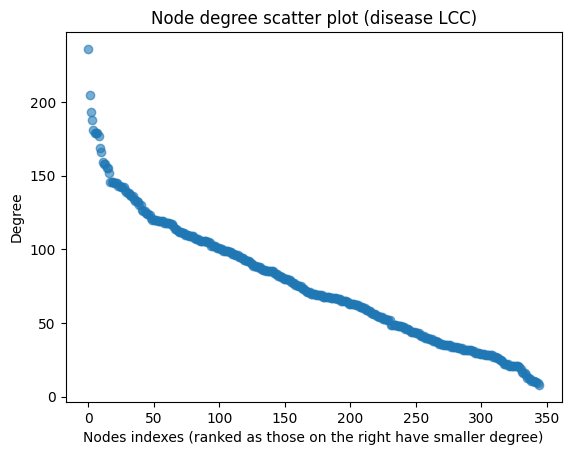

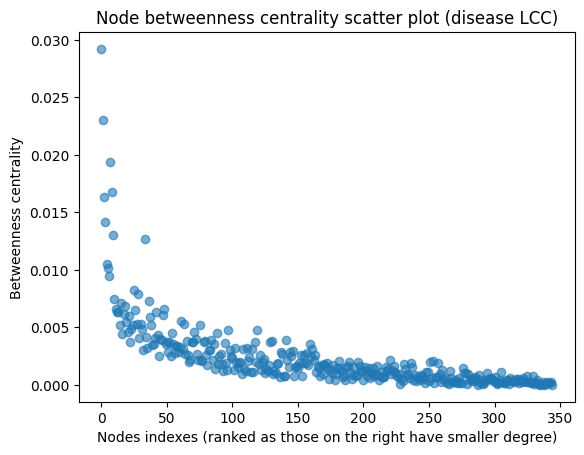

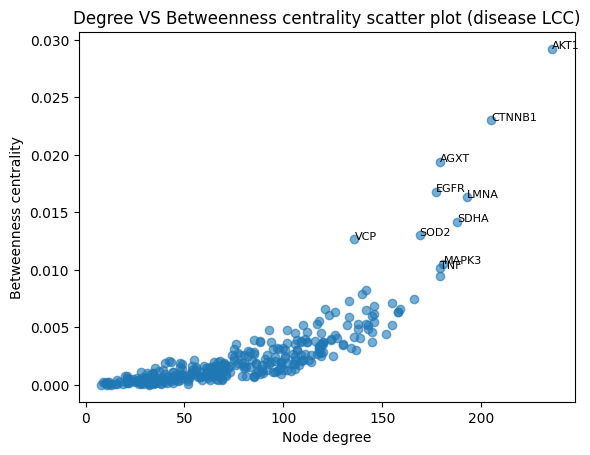

In [15]:
degree_values = [d for d in metrics_largest_LCC['degree'].tolist()]
betweenness_values = [d for d in metrics_largest_LCC['betweenness'].tolist()]

# TODO : See if this scatter is relevant
plt.scatter(range(len(degree_values)), degree_values, alpha=0.6)
plt.xlabel("Nodes indexes (ranked as those on the right have smaller degree)")
plt.ylabel("Degree")
plt.title("Node degree scatter plot (disease LCC)")
plt.show()

# TODO : See if this scatter is relevant
plt.scatter(range(len(betweenness_values)), betweenness_values, alpha=0.6)
plt.xlabel("Nodes indexes (ranked as those on the right have smaller degree)")
plt.ylabel("Betweenness centrality")
plt.title("Node betweenness centrality scatter plot (disease LCC)")
plt.show()

# TODO : check (ask the prof ?) if this scatter is the one he wants ?
plt.scatter(degree_values, betweenness_values, alpha=0.6)
for node in metrics_largest_LCC['Node']:
    # We add gene symbols on the graph for significative genes (in terms of betweenness)
    if betweenness[node] > 0.01:
        plt.text(degrees[node], betweenness[node], node, fontsize=8)
plt.xlabel("Node degree")
plt.ylabel("Betweenness centrality")
plt.title("Degree VS Betweenness centrality scatter plot (disease LCC)")
plt.show()

As we can see, there is a correlation between node degree and betweenness centrality. The more connected is the node, the geater is the betweenness centrality.

Betweenness centrality is the measure of how much a node is a "bridge/bottleneck" in other node pathways.

The most interesting nodes would be those with low degree and high betweenness ! Unfortunately here this scenario is doesn't appear. Maybe for `VCP` gene but not enough evidence...

## 2. Comparative analysis of disease genes identification algorithms

### 2.1 Use algorithms to infer and then validate putative disease genes.

2.1.1 DIAMOnD, default parameters

In [299]:
# With n=200, running for ~1 minute
#!python3 DIAMOnD.py Files/Biogrid.txt Files/Cardiomyopathy.txt 200 Files/diamond_output_200.txt

2.1.2 Diffusion-based, diffusion times: t=[0.1, 1.0, 2.0, 5.0, 10.0]

In [ ]:
# With t=0.1, running for ~4 seconds
#!python3 HeatDiffusion.py Files/Biogrid.txt Files/Cardiomyopathy.txt 200 0.1 Files/heat_diffusion_output_0.1.txt

2.1.3 OPTIONAL : Run Proconsul

### 2.2 Computational validation

2.2.1 For each interactome: perform a 5-fold cross validation in the following way

Split the disease genes set $S_0$ into 5 subsets.

For each fold, select one subset as probe set $S_P$ and the remaining four subsets as training set $S_T$.

For every fold, run both algorithms on all four interactomes (8 combinations, 40 runs total) using the training $S_T$ sets.

In [305]:
def run_algo(algo, network, train_set, output_file, fold_idx, n, t=None):
    """
    Run DIAMOnD algorithm on the selected fold, save prediction.

    Params :
    - algo : algorithm to run ["diamond" | "heatdiffusion"]
    - network : interactome
    - train_set : subset of disease gene
    - output_file : name/path for the saved file
    - fold_idx : index of the current fold
    - n : number of disease genes to predict
    - t : diffusion times (for heatdiffusion)
    """

    if algo=="diamond":
        print("Running Diamond for ~1 minute")
        diamond_script = "DIAMOnD.py"
        cmd = ['python3', diamond_script, network, train_set, str(n), output_file]
    elif algo=="heatdiffusion":
        print("Running heat diffusion for few seconds")
        diamond_script = "HeatDiffusion.py"
        assert(t!=None)
        cmd = ['python3', diamond_script, network, train_set, str(n), str(t), output_file]
    else:
        raise AttributeError(algo+" not found. Shoud be 'diamond' or 'heatdiffusion'.")

    print(f"Running: {' '.join(cmd)}")
    try:
        result = subprocess.run(cmd, check=True, capture_output=True, text=True)
        print(f"✓ Fold {fold_idx} completed successfully")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print(f"✗ Error in Fold {fold_idx}")
        print(e.stderr)

In [306]:
from sklearn.model_selection import KFold

def run_algo_on_one_interactome(interactome, disease, K, n, try_multiple_t=False):
    """
    Create K-folds and run algorithms for the specified interactome for the K folds.
    
    Parameters :
    - interactome : path to the interactome file
    - disease : set of disease genes
    - K : number of folds
    - n : number of genes to predict
    - try_multiple_t : if testing different values of diffusion time
    """

    # Load folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)

    # Iterate on each fold (train, test)
    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(disease), 1):
        print(f"Processing Fold {fold_idx}")
        
        # Get the disease genes from the current train and test fold
        train_genes = [disease[i] for i in train_idx]
        test_genes = [disease[i] for i in test_idx]
        train_file = f'Files/Folds/train_fold_{fold_idx}.txt'
        test_file = f'Files/Folds/test_fold_{fold_idx}.txt'
        
        # Save train (for algorithms)
        with open(train_file, 'w') as f:
            f.write('\n'.join(train_genes))
        
        # Save test (to evaluate)
        with open(test_file, 'w') as f:
            f.write('\n'.join(test_genes))

        # Diamond
        run_algo("diamond", interactome, train_file, f'Files/Folds/{interactome.removesuffix(".txt").removeprefix("Files/")}_diamond_results_fold_{fold_idx}.txt', fold_idx, n)

        # Heat diffusion
        if try_multiple_t:
            t = [0.1, 1.0, 2.0, 5.0, 10.0]
            for time in t:
                output_file = f'Files/Folds/{interactome.removesuffix(".txt").removeprefix("Files/")}_heatdiffusion_results_fold_{fold_idx}_{time}.txt'
                run_algo("heatdiffusion", interactome, train_file, output_file, fold_idx, n, t=time)
        else:
            t = 1.0 # time diffusion selected after comparing in 'try_multiple_t' mode
            output_file = f'Files/Folds/{interactome.removesuffix(".txt").removeprefix("Files/")}_heatdiffusion_results_fold_{fold_idx}_{t}.txt'
            run_algo("heatdiffusion", interactome, train_file, output_file, fold_idx, n, t=t)

In [ ]:
print("Running for ~32 minutes...")

run_algo_on_one_interactome("Files/Biogrid.txt", disease, K=5, n=200, try_multiple_t=False)
run_algo_on_one_interactome("Files/Huri.txt", disease, K=5, n=200, try_multiple_t=False)
run_algo_on_one_interactome("Files/String.txt", disease, K=5, n=200, try_multiple_t=False)
run_algo_on_one_interactome("Files/Reactome.txt", disease, K=5, n=200, try_multiple_t=False)

Evaluate each run by checking how many genes from the probe set $S_P$ appear in the algorithm’s output.

In [364]:
def evaluate_predictions(prediction_file, true_file, top_X=None):
    """
    Evaluate the algorithm by comparing the expected genes from test_set with the set of genes in the result_file
    
    Parameters :
    - prediction_file : path to the file containing the predictions of disease genes obtained after running the algorithms
    - true_genes_file : set of genes expected in the result_file
    - top_X : to evalute only on top X genes in prediction_file

    Returns :
    - Dictionnary with all the metrics
    """

    # Creates a set with the real disease genes
    true_genes = {line.strip() for line in open(true_file)}

    # If top_X not provided, we analyse the whole file (top_X = nb lines)
    if top_X==None:
        with open(prediction_file) as f:
            top_X = len(f.readlines())

    # Creates a set with the predicted genes
    predicted_genes = {
        line.strip().split('\t')[1]
        for i, line in enumerate(open(prediction_file))
        if not line.startswith('#') and i < top_X # We skip the first line (with "#") and stop until top_X
    }

    # Compute true positive, false positive and false negative for the metrics
    TP = len(predicted_genes & true_genes)
    FP = len(predicted_genes - true_genes)
    FN = len(true_genes - predicted_genes)

    # Compute required metrics
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'TP': TP,
        'FP': FP,
        'FN': FN
    }


In [ ]:
def iterate_prediction(top_X=None):
    interactomes = ["Biogrid", "Huri", "Reactome", "String"]
    results_data = []

    # Iterate on each fold
    for fold in range(1, 6):
        # Iterate on each interactome
        for interactome in interactomes:
            for X in (top_X if top_X is not None else [None]):
                # Diamond
                results_diamond = evaluate_predictions(
                    prediction_file=f'Files/Folds/{interactome}_diamond_results_fold_{fold}.txt',
                    true_file=f'Files/Folds/test_fold_{fold}.txt',
                    top_X=X
                )
                results_data.append({
                    'Top_X': X,
                    'Fold': fold,
                    'Interactome': interactome,
                    'Algorithm': 'Diamond',
                    'Precision': results_diamond['precision'],
                    'Recall': results_diamond['recall'],
                    'F1': results_diamond['f1'],
                    'TP': results_diamond['TP'],
                    'FN': results_diamond['FN']
                })
                
                # Heat Diffusion
                results_heat = evaluate_predictions(
                    prediction_file=f'Files/Folds/{interactome}_heatdiffusion_results_fold_{fold}_1.0.txt',
                    true_file=f'Files/Folds/test_fold_{fold}.txt',
                    top_X=X
                )
                results_data.append({
                        'Top_X': X,
                        'Fold': fold,
                        'Interactome': interactome,
                        'Algorithm': 'HeatDiffusion',
                        'Precision': results_heat['precision'],
                        'Recall': results_heat['recall'],
                        'F1': results_heat['f1'],
                        'TP': results_heat['TP'],
                        'FN': results_heat['FN']
                    })
                
    return results_data

In [377]:
def print_summary_metrics(df):
    # Comparing algorithms and interactomes
    algo_comparison = df.groupby('Algorithm')['Recall'].agg(['mean', 'std', 'min', 'max'])
    algo_comparison['mean_pct'] = algo_comparison['mean'] * 100
    algo_comparison['std_pct'] = algo_comparison['std'] * 100

    interactome_comparison = df.groupby('Interactome')['Recall'].agg(['mean', 'std', 'min', 'max'])
    interactome_comparison['mean_pct'] = interactome_comparison['mean'] * 100
    interactome_comparison['std_pct'] = interactome_comparison['std'] * 100
    interactome_comparison = interactome_comparison.sort_values('mean_pct', ascending=False)

    # ============================================================================
    # Executive summary
    # ============================================================================
    print("\n" + "="*80)
    print("EXECUTIVE SUMMARY")
    print("="*80)

    best_algo = algo_comparison['mean_pct'].idxmax()
    best_algo_recall = algo_comparison.loc[best_algo, 'mean_pct']

    best_interactome_overall = interactome_comparison['mean_pct'].idxmax()
    best_interactome_recall = interactome_comparison.loc[best_interactome_overall, 'mean_pct']

    # Best combinaison
    best_combo = df.groupby(['Algorithm', 'Interactome'])['Recall'].mean().idxmax()
    best_combo_recall = df.groupby(['Algorithm', 'Interactome'])['Recall'].mean().max() * 100

    print(f"""
    1. Best Algorithm:     {best_algo} ({best_algo_recall:.2f}% average recall)
    2. Best Interactome:   {best_interactome_overall} ({best_interactome_recall:.2f}% average recall)
    3. Best Combination:   {best_combo[0]} + {best_combo[1]} ({best_combo_recall:.2f}% recall)
    """)

    # ============================================================================
    # Visualizing
    # ============================================================================
    fig, axes = plt.subplots(3, 1, figsize=(10, 10))

    # Plot 1: Barplot - Algorithmes
    algo_means = df.groupby('Algorithm')['Recall'].mean() * 100
    axes[0].bar(algo_means.index, algo_means.values, color=['blue', 'red'])
    axes[0].set_ylabel('Average Recall (%)', fontsize=12)
    axes[0].set_title('Algorithm Comparison', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    for i, v in enumerate(algo_means.values):
        axes[0].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

    # Plot 2: Barplot - Interactomes
    interactome_means = df.groupby('Interactome')['Recall'].mean().sort_values(ascending=False) * 100
    axes[1].bar(interactome_means.index, interactome_means.values, 
                color=['green', 'orange', 'purple', 'blue'])
    axes[1].set_ylabel('Average Recall (%)', fontsize=12)
    axes[1].set_title('Interactome Comparison', fontsize=14, fontweight='bold')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    for i, v in enumerate(interactome_means.values):
        axes[1].text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')

    # Plot 3: Heatmap - Algorithm × Interactome
    heatmap_data = df.pivot_table(values='Recall', index='Interactome', 
                                columns='Algorithm', aggfunc='mean') * 100
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='YlOrRd', 
                ax=axes[2], cbar_kws={'label': 'Recall (%)'})
    axes[2].set_title('Recall Heatmap: Algorithm × Interactome', 
                        fontsize=14, fontweight='bold')

    plt.tight_layout()

In [383]:
# Create dataframe

results_data = iterate_prediction(top_X=None)
df = pd.DataFrame(results_data)

# Create a dataframe specific to display only what's ask in this questions
display_df = df.assign(**{
        'Disease genes found': df['TP'],
        'Total disease genes': df['TP'] + df['FN']
    })[['Fold','Interactome','Algorithm','Disease genes found','Total disease genes']]

print("\n" + "="*80)
print("DETAILED RESULTS (all folds)")
print("="*80)
print(display_df.to_string(index=False))


DETAILED RESULTS (all folds)
 Fold Interactome     Algorithm  Disease genes found  Total disease genes
    1     Biogrid       Diamond                    2                   74
    1     Biogrid HeatDiffusion                   14                   74
    1        Huri       Diamond                    0                   74
    1        Huri HeatDiffusion                    2                   74
    1    Reactome       Diamond                    5                   74
    1    Reactome HeatDiffusion                   15                   74
    1      String       Diamond                   26                   74
    1      String HeatDiffusion                   31                   74
    2     Biogrid       Diamond                    3                   75
    2     Biogrid HeatDiffusion                    7                   75
    2        Huri       Diamond                    1                   75
    2        Huri HeatDiffusion                    2                   75
    2   

2.2.2 Compute the following performance metrics for all the combinations algorithm/interactome:
- precision (average SD)
- recall (average SD)
- F1-score (average SD)

Precision : $$\frac{\text{True positive}}{\text{True Positive + False Positive}}$$

Recall : $$\frac{\text{True positive}}{\text{True Positive + False Negative}}$$

F1-Score : $$ 2 * \frac{\text{precision} * \text{recall}}{\text{precision + recall}}$$

- **True positive** corresponds to predicted real disease genes
- **False positive** corresponds to predicted not disease genes
- **False negative** corresponds to the disease genes not found

In [379]:
metrics_summary = (
    df
    .groupby(['Algorithm', 'Interactome'])
    .agg({
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1': ['mean', 'std']
    })
)

# Display
metrics_summary.columns = [
    f"{metric}_{stat}"
    for metric, stat in metrics_summary.columns
]

metrics_summary = metrics_summary.reset_index()

metrics_summary

,Algorithm,Interactome,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
0,Diamond,Biogrid,0.015,0.009,0.040,0.023,0.022,0.013
1,Diamond,Huri,0.005,0.006,0.013,0.017,0.007,0.009
2,Diamond,Reactome,0.036,0.007,0.097,0.017,0.052,0.009
3,Diamond,String,0.087,0.028,0.234,0.075,0.127,0.041
4,HeatDiffusion,Biogrid,0.040,0.020,0.108,0.054,0.058,0.029
5,HeatDiffusion,Huri,0.010,0.006,0.027,0.017,0.015,0.009
6,HeatDiffusion,Reactome,0.060,0.010,0.161,0.028,0.087,0.015
7,HeatDiffusion,String,0.109,0.028,0.293,0.076,0.159,0.041



EXECUTIVE SUMMARY

    1. Best Algorithm:     HeatDiffusion (14.73% average recall)
    2. Best Interactome:   String (26.37% average recall)
    3. Best Combination:   HeatDiffusion + String (29.33% recall)
    


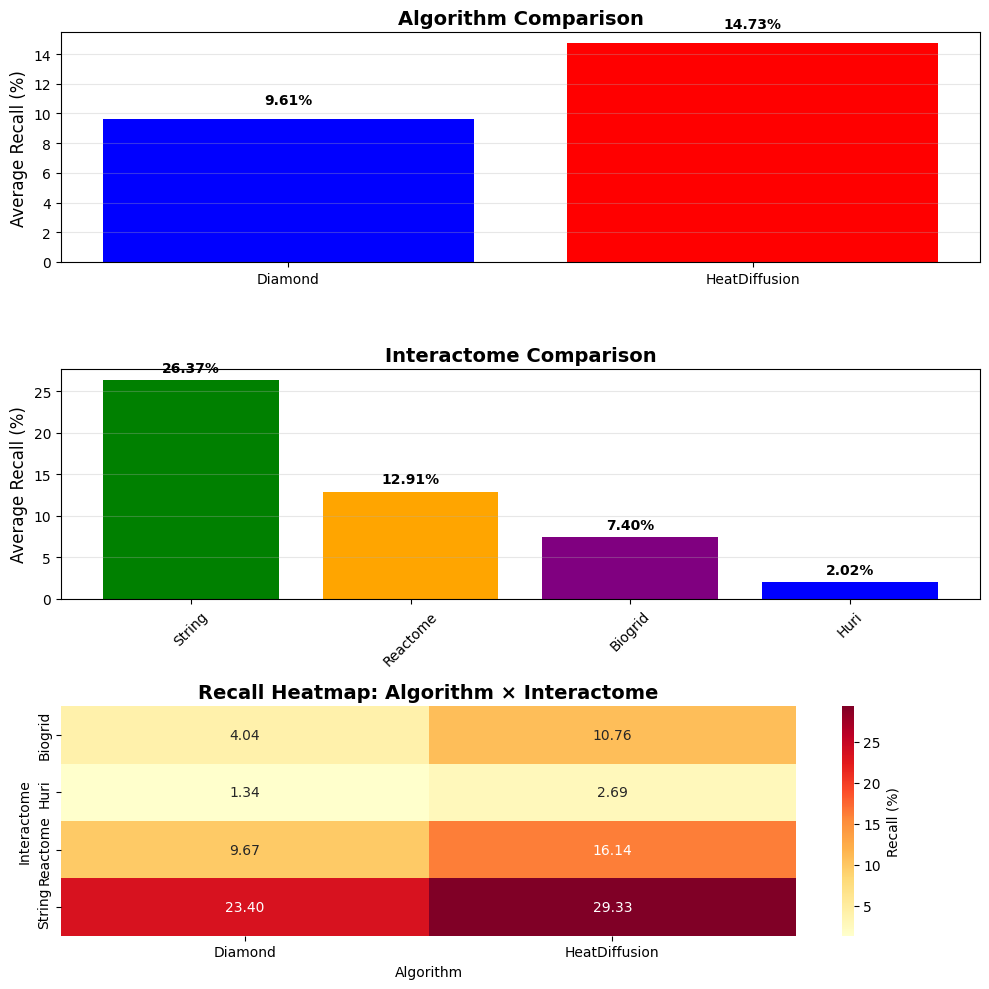

In [380]:
print_summary_metrics(df)

In conclusion, the best combinasion is using String interactome with the heat diffusion algorithm.

2.2.3 Provide the performance measures selecting the top 50 positions and the top X positions where $X$ = $\frac{n}{8}$, $\frac{n}{4}$, $\frac{n}{2}$, $n$, with n=number of known GDAs (i.e., number of disease’s seed genes)

In our case we have n=373 disease genes in $S_0$. So we'll keep the following top_X :
- $X = 50$
- $X = \frac{n}{8} = 47$
- $X = \frac{n}{4} = 93$
- $X = \frac{n}{2} = 186$
- $X = n = 373$

In [381]:
n = len(disease) # n = number of total disease gene set (S_0)
top_X = [50, round(n/8), round(n/4), round(n/2), n]

results_data_topX = iterate_prediction(top_X=top_X)
# Create dataframe
df_topX = pd.DataFrame(results_data_topX)

metrics_summary_topX = (
    df_topX
    .groupby(['Top_X', 'Algorithm', 'Interactome'])
    .agg({
        'Precision': ['mean', 'std'],
        'Recall': ['mean', 'std'],
        'F1': ['mean', 'std']
    })
)

# Display
metrics_summary_topX.columns = [
    f"{metric}_{stat}"
    for metric, stat in metrics_summary_topX.columns
]

metrics_summary_topX = metrics_summary_topX.reset_index()

metrics_summary_topX

,Top_X,Algorithm,Interactome,Precision_mean,Precision_std,Recall_mean,Recall_std,F1_mean,F1_std
0,47,Diamond,Biogrid,0.030,0.019,0.019,0.012,0.023,0.015
1,47,Diamond,Huri,0.009,0.019,0.005,0.012,0.007,0.015
2,47,Diamond,Reactome,0.109,0.015,0.067,0.009,0.083,0.011
3,47,Diamond,String,0.283,0.102,0.175,0.064,0.216,0.078
4,47,HeatDiffusion,Biogrid,0.048,0.018,0.030,0.011,0.037,0.014
5,47,HeatDiffusion,Huri,0.022,0.015,0.013,0.010,0.017,0.012
6,47,HeatDiffusion,Reactome,0.109,0.022,0.067,0.014,0.083,0.017
7,47,HeatDiffusion,String,0.283,0.074,0.175,0.046,0.216,0.057
8,50,Diamond,Biogrid,0.029,0.018,0.019,0.012,0.023,0.014
9,50,Diamond,Huri,0.012,0.018,0.008,0.012,0.010,0.015



EXECUTIVE SUMMARY

    1. Best Algorithm:     HeatDiffusion (10.63% average recall)
    2. Best Interactome:   String (21.57% average recall)
    3. Best Combination:   HeatDiffusion + String (22.81% recall)
    


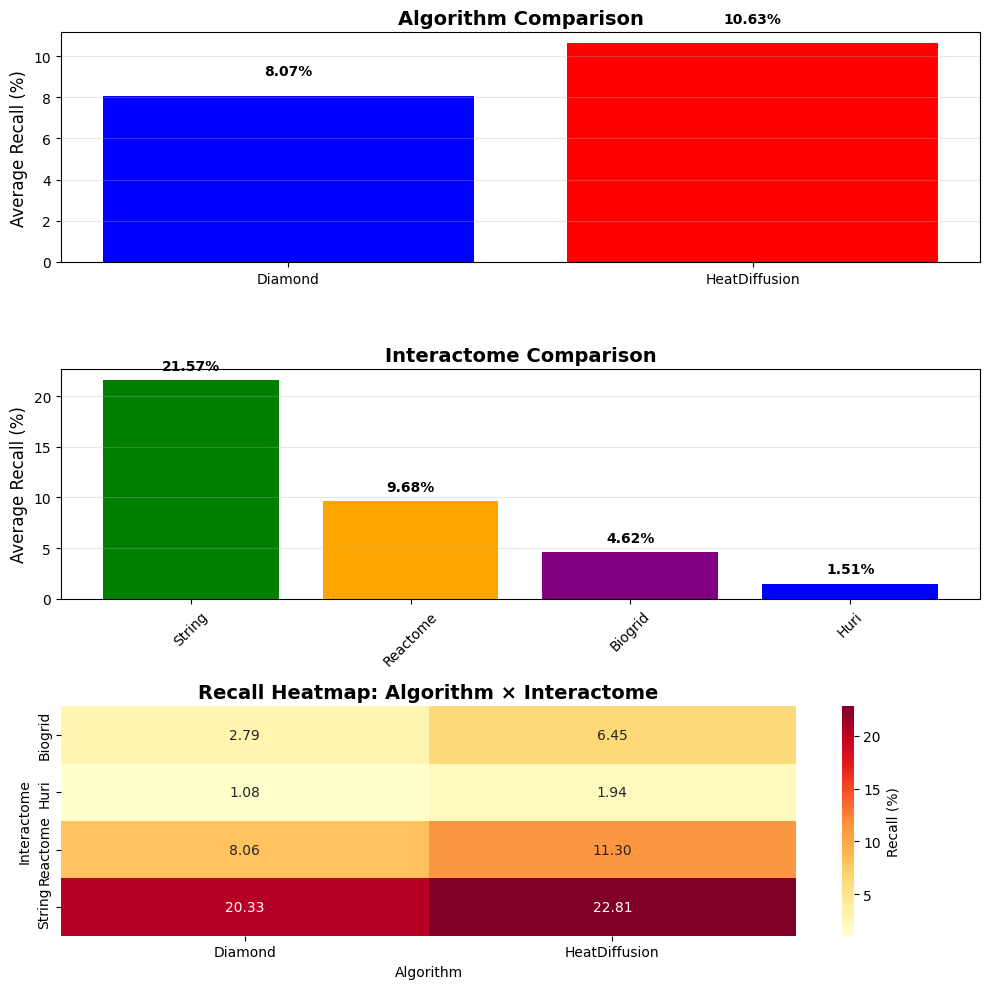

In [382]:
print_summary_metrics(df_topX)

In conclusion, even after evaluating on several top_X predicted genes, we still have the best combination : String interactome with heat diffusion algorithm.

## 3. Putative disease gene identification

In [102]:
# TODO (Stella ?)

## 4. Drug repurposing

In [101]:
# TODO (Annet ?)